<table>
  <tr>
    <td><center><img src="img/mlhep-logo-transparent.png" width="400"></center></td>
    <td><h1><center>The Sixth Machine Learning in High Energy Physics Summer School (MLHEP) 2020</center></h1></td>
  </tr>
 </table>

<h1><center>Seminar</center></h1>
<h2><center>Feature engineering, importance and selection</center></h2>

# About

The goal of this seminar is to demonstrate several ways how to estimate feature importances and to use them for the best feature selection.

In [1]:
import pandas as pd
import numpy as np
import numpy.testing as np_testing
import matplotlib.pyplot as plt

%matplotlib inline

# Part 1: Feature importance

### Data preparation

UCI MAGIC dataset: https://archive.ics.uci.edu/ml/datasets/magic+gamma+telescope

The data are MC generated (see below) to simulate registration of high energy gamma particles in a ground-based atmospheric Cherenkov gamma telescope using the imaging technique. Cherenkov gamma telescope observes high energy gamma rays, taking advantage of the radiation emitted by charged particles produced inside the electromagnetic showers initiated by the gammas, and developing in the atmosphere. This Cherenkov radiation (of visible to UV wavelengths) leaks through the atmosphere and gets recorded in the detector, allowing reconstruction of the shower parameters. The available information consists of pulses left by the incoming Cherenkov photons on the photomultiplier tubes, arranged in a plane, the camera. Depending on the energy of the primary gamma, a total of few hundreds to some 10000 Cherenkov photons get collected, in patterns (called the shower image), allowing to discriminate statistically those caused by primary gammas (signal) from the images of hadronic showers initiated by cosmic rays in the upper atmosphere (background).

Features description:
- **Length:** continuous # major axis of ellipse [mm]
- **Width:** continuous # minor axis of ellipse [mm]
- **Size:** continuous # 10-log of sum of content of all pixels [in #phot]
- **Conc:** continuous # ratio of sum of two highest pixels over fSize [ratio]
- **Conc1:** continuous # ratio of highest pixel over fSize [ratio]
- **Asym:** continuous # distance from highest pixel to center, projected onto major axis [mm]
- **M3Long:** continuous # 3rd root of third moment along major axis [mm]
- **M3Trans:** continuous # 3rd root of third moment along minor axis [mm]
- **Alpha:** continuous # angle of major axis with vector to origin [deg]
- **Dist:** continuous # distance from origin to center of ellipse [mm]
- **Label:** g,h # gamma (signal), hadron (background)

g = gamma (signal): 12332 \
h = hadron (background): 6688

In [2]:
f_names = np.array(["Length", "Width", "Size", "Conc", "Conc1", "Asym", "M3Long", "M3Trans", "Alpha", "Dist"])

data = pd.read_csv("data/MAGIC/magic04.data", header=None, names=list(f_names)+["Label"])
data.head()

,Length,Width,Size,Conc,Conc1,Asym,M3Long,M3Trans,Alpha,Dist,Label
0,28.7967,16.0021,2.6449,0.3918,0.1982,27.7004,22.0110,-8.2027,40.0920,81.8828,g
1,31.6036,11.7235,2.5185,0.5303,0.3773,26.2722,23.8238,-9.9574,6.3609,205.2610,g
2,162.0520,136.0310,4.0612,0.0374,0.0187,116.7410,-64.8580,-45.2160,76.9600,256.7880,g
3,23.8172,9.5728,2.3385,0.6147,0.3922,27.2107,-6.4633,-7.1513,10.4490,116.7370,g
4,75.1362,30.9205,3.1611,0.3168,0.1832,-5.5277,28.5525,21.8393,4.6480,356.4620,g


In [3]:
# prepare a matrix of input features
X = data[f_names].values

# prepare a vector of true labels
y = 1 * (data['Label'].values == "g")

In [4]:
from sklearn.model_selection import train_test_split

# split the data into train and test subsamples to fit and test classifiers
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=11, stratify=y)

## Gradient Boosting based feature importances

<center><img src="img/tree.png" width="400"></center>

Let $T(f)$ be the set of all nodes which use feature $f$ to make split. Then, feature importance $Imp(f)$ of $f$:

$$
Imp(f) = \sum_{t \in T(f)} n_t \Delta I(t)
$$

$$
\Delta I(t) = I(t) - \sum_{c \in children} \frac{n_c}{n_t} I(c)
$$

where
- $n_{t}$ - number of objects in node $t$;
- $I(t)$ – impurity function (gini, cross-entropy, MSE) value for the node.

Feature importances estimated by each tree in an ensemble are averaged over all trees in this ensemble.

In [5]:
# this function will be used just to plot feature importances

def plot_feature_importances(f_imps, f_names, title=""):
    f_imps = np.array(f_imps)
    f_names = np.array(f_names)
    sort_inds = np.argsort(f_imps)
    yy = np.arange(len(f_imps)).astype(np.int)
    plt.barh(yy, f_imps[sort_inds])
    plt.yticks(yy, f_names[sort_inds], size=14)
    plt.xticks(size=14)
    plt.xlabel("Feature importance", size=14)
    plt.title(title, size=14)
    plt.show()

In [6]:
# import quality metrics and GradientBoostingClassifier
from sklearn import metrics
from sklearn.ensemble import GradientBoostingClassifier

# define a classifier
gb = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=11)

# fit it using the train subsample
gb.fit(X_train, y_train)

# get predictions for the test subsample
y_test_proba = gb.predict_proba(X_test)[:, 1]

# compute roc auc score on the test
roc_auc_gb = metrics.roc_auc_score(y_test, y_test_proba)
print("Test ROC AUC: ", roc_auc_gb)

Test ROC AUC:  0.9235232772481287


In [7]:
# get feature imporatnces
f_imps_gb = gb.feature_importances_

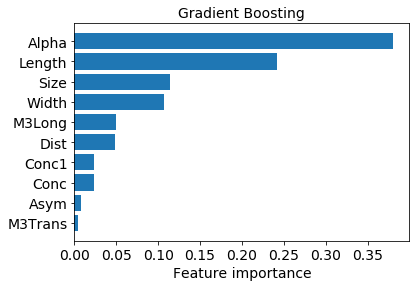

In [8]:
# display the feature importances
plot_feature_importances(f_imps_gb, f_names, "Gradient Boosting")

## Linear model based feature importances

Consider a linear model with regularization ($L_1$ or $L_2$ penalty):

$$
\hat{y}=w_0 + w_1 f_1+ w_2 f_2 + ... + w_k f_k
$$

If features are normalized (have the same ranges), feature importance $Imp(f_i)$ of $f_i$ is equal to:

$$
Imp(f_i) = | w_i |
$$


### Task 1
Estimate feature importacnes using linear model as it is described above.

**Hints:** use `StandardScaler()` to normalize feature values. Also, use `LogisticRegression(solver='liblinear', penalty='l2', C=C, random_state=11)` for the linear model. To get values of the model coefficients use `<model>.coef_[0]` method.

In [9]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

def get_feature_imp_with_lin_mod(X_train, y_train, C=1.0):
    """
    Estimate feature importances using linear model with regularization.

    Parameters:
    -----------
    X_train: numpy.ndarray
        Object features matrix.
    y_train: numpy.array
        Vector of true class labels.
    C: float
        Inverse of regularization strength; must be a positive float.
    
    Returns:
    --------
    f_imps_lin: numpy.array
        Estimated feature importances.
    """

    # normalize feature values
    ss = StandardScaler()
    ss.fit(X_train)
    X_train_ss = ss.transform(X_train)

    ### BEGIN SOLUTION
    # fit a linear model with regularization
    linclf = LogisticRegression(solver='liblinear', penalty='l2', C=C, random_state=11)
    linclf.fit(X_train_ss, y_train)
    
    # get feature importances
    f_imps_lin = np.abs(linclf.coef_[0])
    ### END SOLUTION
    
    return f_imps_lin

In [10]:
f_imps_lin = get_feature_imp_with_lin_mod(X_train, y_train, C=1.)
f_imps_lin

array([1.23276898, 0.08849417, 0.31007411, 0.07866152, 0.69042639,
       0.01030818, 0.31858178, 0.01445776, 1.20855327, 0.0711564 ])

Expected output:

<center>   
    
```python
array([1.23276898, 0.08849417, 0.31007411, 0.07866152, 0.69042639,
       0.01030818, 0.31858178, 0.01445776, 1.20855327, 0.0711564 ])
    
``` 
    
</center>

In [11]:
### BEGIN HIDDEN TESTS
actual  = f_imps_lin
desired = np.array([1.23276898, 0.08849417, 0.31007411, 0.07866152, 0.69042639,
                    0.01030818, 0.31858178, 0.01445776, 1.20855327, 0.0711564 ])
np_testing.assert_almost_equal(actual, desired, decimal=3)
### END HIDDEN TESTS

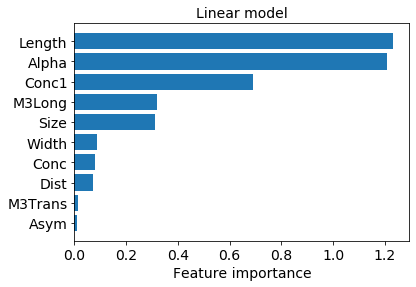

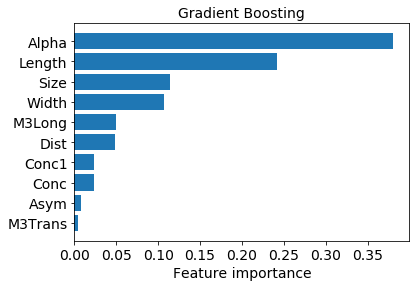

In [12]:
# display the feature importances
plot_feature_importances(f_imps_lin, f_names, "Linear model")
plot_feature_importances(f_imps_gb, f_names, "Gradient Boosting")

Do you have any ideas why the feature importances are so different for these two models? Let's compare quality of the models.

In [13]:
# normalize feature values
ss = StandardScaler()
ss.fit(X_train)
X_train_ss = ss.transform(X_train)
X_test_ss = ss.transform(X_test)

# fit a linear model with regularization
linclf = LogisticRegression(solver='liblinear', penalty='l2', C=1.0, random_state=11)
linclf.fit(X_train_ss, y_train)

# get predictions for the test subsample
y_test_proba = linclf.predict_proba(X_test_ss)[:, 1]

# compute roc auc score on the test
roc_auc_lin = metrics.roc_auc_score(y_test, y_test_proba)

print("Test ROC AUC (GB)    : ", roc_auc_gb)
print("Test ROC AUC (LogReg): ", roc_auc_lin)

Test ROC AUC (GB)    :  0.9235232772481287
Test ROC AUC (LogReg):  0.8367647789157084


## General method

<center><img src="img/general.png" width="500"></center>

Algorithm:
- Train your model
- Calculate quality measure $Q_0$ on the test set
- For a feature $f$:
 - Replace given values with random values from the same distribution (perform random shuffling)
 - Calculate quality measure $Q_f$ on the test set
 - Estimate feature importance: $Imp(f)=Q_0 - Q_f$


### Task 2

Estimate feature importances using general algorithm described above. 

**Hint:** to shuffle values of one feature use `numpy.random.RandomState(42).shuffle()`, for an example: `X[:, i] = np.random.RandomState(42).shuffle(X[:, i])`

In [14]:
# define a model that we will use to estimate feature importances
model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=11)

# fit the model on the train sample
model.fit(X_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=11, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [15]:
model.predict_proba(X_test)

array([[0.2978063 , 0.7021937 ],
       [0.9876682 , 0.0123318 ],
       [0.16295925, 0.83704075],
       ...,
       [0.28701715, 0.71298285],
       [0.02913714, 0.97086286],
       [0.4516622 , 0.5483378 ]])

In [16]:
def get_feature_imp_general(X_test, y_test, model):
    """
    Estimate feature importances using linear model with regularization.

    Parameters:
    -----------
    X_test: numpy.ndarray
        Object features matrix.
    y_test: numpy.array
        Vector of true class labels.
    model: object
        A classifier fitted on the train sample
    
    Returns:
    --------
    f_imps_gen: numpy.array
        Estimated feature importances.
    """
    
    # define a list for the feature importances
    f_imps_gen = []

    # calculate the base quality value according to the algorithm
    y_test_proba = model.predict_proba(X_test)[:, 1]
    q_0 = metrics.roc_auc_score(y_test, y_test_proba)

    # for each feature in the sample estimate its importance
    for i in range(X_test.shape[1]):
        
        # do not forget to make a copy of X_test!
        X_test_copy = X_test.copy()
        
        # shuffle values of the i-th feature
        ### BEGIN SOLUTION
        X_test_copy[:, i] = np.random.RandomState(42).shuffle(X_test_copy[:, i])
        ### END SOLUTION
        
        # calculate quality metric value
        X_test_copy = np.nan_to_num(X_test_copy)
        y_test_proba = model.predict_proba(X_test_copy)[:, 1]
        q_f = metrics.roc_auc_score(y_test, y_test_proba)
        
        # estimate importance of the feature
        imp = q_0 - q_f
        f_imps_gen.append(imp)
        
    return np.array(f_imps_gen)

In [17]:
f_imps_gen = get_feature_imp_general(X_test, y_test, model)
f_imps_gen

array([0.04537013, 0.06596446, 0.08269023, 0.00817734, 0.00350842,
       0.00091059, 0.00249184, 0.00053674, 0.11450679, 0.09304359])

Expected output (approximately):

<center>   
    
```python
array([0.04537013, 0.06596446, 0.08269023, 0.00817734, 0.00350842,
       0.00091059, 0.00249184, 0.00053674, 0.11450679, 0.09304359])
    
``` 
    
</center>

In [18]:
### BEGIN HIDDEN TESTS
actual  = f_imps_gen
desired = np.array([0.04537013, 0.06596446, 0.08269023, 0.00817734, 0.00350842,
                    0.00091059, 0.00249184, 0.00053674, 0.11450679, 0.09304359])
np_testing.assert_almost_equal(actual, desired, decimal=2)
### END HIDDEN TESTS

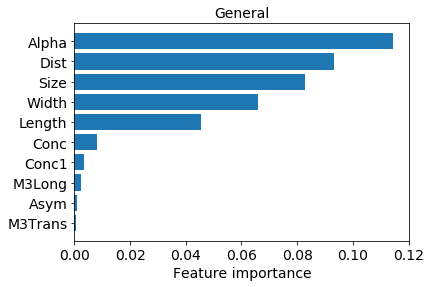

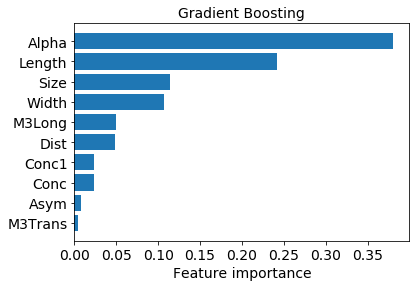

In [19]:
plot_feature_importances(f_imps_gen, f_names, "General")
plot_feature_importances(f_imps_gb, f_names, "Gradient Boosting")

# Part 2: Feature selection

## Recursive feature elimination

- Train a model on the full set of features
- Estimate feature importance (based on the model)
- Remove the least important feature
- Repeat

### Task 3
Implement recursive feature elimination using `model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=11)` as a model.

**Hint:** use feature importances estimated by the model `model.feature_importances_`.

In [20]:
# make copies for further steps
X_train_curr = X_train.copy()
X_test_curr  = X_test.copy()
f_names_curr = f_names.copy()

# for storing roc auc scores
roc_auc_scores = []

# eliminate feature by feature
for i in range(X.shape[1]):
    
    print("Features: ", f_names_curr)
    
    # 1. fit the model using current set of festures
    # 2. get feature importances
    ### BEGIN SOLUTION
    # fit the model using current set of festures
    model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=11)
    model.fit(X_train_curr, y_train)
    
    # get feature importances
    f_imps = model.feature_importances_
    ### END SOLUTION
    
    # compute roc auc of the model
    y_test_proba = model.predict_proba(X_test_curr)[:, 1]
    auc = metrics.roc_auc_score(y_test, y_test_proba)
    
    # print and store it
    auc = np.round(auc, 4)
    print("ROC AUC: ", auc)
    roc_auc_scores.append(auc)

    # remove feature with the least importance
    X_train_curr = X_train_curr[:, f_imps > f_imps.min()]
    X_test_curr  = X_test_curr[:, f_imps > f_imps.min()]
    f_names_curr = f_names_curr[f_imps > f_imps.min()]
    
    print("\n")
    
print("Output: ", roc_auc_scores)

Features:  ['Length' 'Width' 'Size' 'Conc' 'Conc1' 'Asym' 'M3Long' 'M3Trans' 'Alpha'
 'Dist']
ROC AUC:  0.9235


Features:  ['Length' 'Width' 'Size' 'Conc' 'Conc1' 'Asym' 'M3Long' 'Alpha' 'Dist']
ROC AUC:  0.9232


Features:  ['Length' 'Width' 'Size' 'Conc' 'Conc1' 'M3Long' 'Alpha' 'Dist']
ROC AUC:  0.9229


Features:  ['Length' 'Width' 'Size' 'Conc1' 'M3Long' 'Alpha' 'Dist']
ROC AUC:  0.9218


Features:  ['Length' 'Width' 'Size' 'M3Long' 'Alpha' 'Dist']
ROC AUC:  0.9187


Features:  ['Length' 'Width' 'Size' 'M3Long' 'Alpha']
ROC AUC:  0.9153


Features:  ['Length' 'Width' 'Size' 'Alpha']
ROC AUC:  0.9113


Features:  ['Length' 'Width' 'Alpha']
ROC AUC:  0.8862


Features:  ['Length' 'Alpha']
ROC AUC:  0.8666


Features:  ['Alpha']
ROC AUC:  0.7823


Output:  [0.9235, 0.9232, 0.9229, 0.9218, 0.9187, 0.9153, 0.9113, 0.8862, 0.8666, 0.7823]


Expected output:

<center>   
    
```python
[0.9235, 0.9232, 0.9229, 0.9218, 0.9187, 0.9153, 0.9113, 0.8862, 0.8666, 0.7823]
    
``` 
    
</center>

In [21]:
### BEGIN HIDDEN TESTS
actual  = roc_auc_scores
desired = [0.9235, 0.9232, 0.9229, 0.9218, 0.9187, 0.9153, 0.9113, 0.8862, 0.8666, 0.7823]
np_testing.assert_almost_equal(actual, desired, decimal=3)
### END HIDDEN TESTS

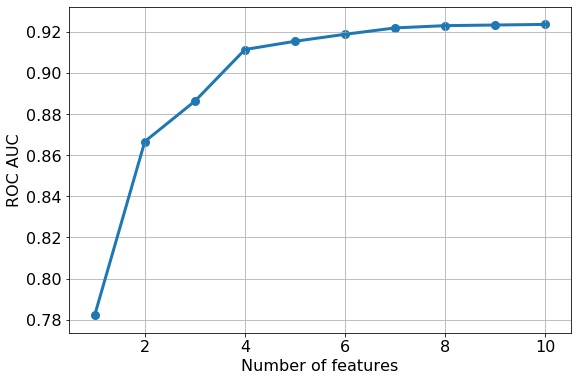

In [22]:
nf = np.arange(1, len(roc_auc_scores)+1)[::-1]
plt.figure(figsize=(9, 6))

plt.plot(nf, roc_auc_scores, linewidth=3)
plt.scatter(nf, roc_auc_scores, linewidth=3)

plt.xlabel("Number of features", size=16)
plt.ylabel("ROC AUC", size=16)
plt.xticks(size=16)
plt.yticks(size=16)
plt.grid(b=1)
plt.show()